In [2]:
from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers import models, losses
from sentence_transformers.util import cos_sim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from glob import glob
from transformers import AutoTokenizer
import re
import pickle, gzip
import sys
from nltk.tokenize import sent_tokenize
import pickle, gzip
from langchain_text_splitters.sentence_transformers import SentenceTransformersTokenTextSplitter
from langchain_text_splitters import CharacterTextSplitter
import matplotlib.pyplot as plt
sys.path.insert(0,'/home/sulcan/Documents/ipac-logbook/code/')
from mmd import *
gd = lambda x,i : x[list(x.keys())[i]]

max_seq_length = 512
min_seq_length = 16
uncase = False
device = 'cuda:0'
epochs = 12

name = f'_min{min_seq_length}_max{max_seq_length}_' + ('un' if uncase else '') + f'cased_plain_scibert-eqplaceholder_{epochs}epochs_'
data_folder = '/home/sulcan/Documents/ipac-logbook/data/data_acc/'
model_folder = f'/home/sulcan/Documents/ipac-logbook/models/simcse/{name}'


if uncase:
    model_name = "allenai/scibert_scivocab_uncased"
    # model_name = 'distilbert/distilbert-base-uncased'
    # model_name = 'princeton-nlp/sup-simcse-roberta-base'
else:
    model_name = "allenai/scibert_scivocab_cased"
    # model_name = 'distilbert/distilbert-base-cased'
    # model_name = 'princeton-nlp/sup-simcse-roberta-base'
    
folders = [f'{data_folder}/arxiv/',\
           f'{data_folder}/jacow/',\
           f'{data_folder}/books/',\
    ]

files = []
for folder in folders:
    files.extend(glob(folder + '*.mmd'))

In [3]:
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length, do_lower_case = uncase)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device = device)
model.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case = uncase)
print(model.tokenizer.decode(model.tokenizer.encode('Hello World')))

[CLS] Hello World [SEP]


## Data Preparation

Opening mmd files, filtering equations, and chining sentences (sent_tokenize)

In [3]:
if False:
    
    # loading data
    print('loading data...')
    data_mmd = {}
    for file in tqdm(sorted(files)):
        with open(file, 'r') as f:
            data_mmd[file] = f.read()
    print('... data loaded')
    
    print('preparing data (equations, tables)...')
    # preparing equations and removing tables
    data_mmd = prepare_mmd_eqations_and_tables_for_simcse(data_mmd)
    print('... data prepared')
    
    
    # splitting into smaller chunks of overlapping text
    train_sentences = []
    
    
    for k in tqdm(data_mmd):
        document = data_mmd[k]
        document = re.sub('\s+',' ', document)
        if len(document) <= 128:
            continue
        train_sentences.extend(text_splitter(document, model.tokenizer, max_seq_length))
    
    # chunking by sentences, trains the model to be quite biased towards rather shorter sentences
    '''
    print('chunking paragraphs into sentences ...')
    # chunking sentences
    train_sentences = []
    for k in tqdm(data_mmd):
        for par in data_mmd[k].split('\n\n'):
            par = re.sub('#+',' ',par)
            par = re.sub('\s+',' ', par)
            train_sentences.extend(sent_tokenize(par))
            
    train_sentences_filtered = []

    for i in tqdm(range(len(train_sentences))):
        sent = train_sentences[i]
        length = len(model.tokenizer.encode(sent))
        if length < max_seq_length and length > min_seq_length:            
            train_sentences_filtered.append(sent)
    train_sentences = train_sentences_filtered

    with gzip.open(f'{data_folder}/train_sentences_{name}.pickle','wb') as f:
         pickle.dump(train_sentences, f)
    
    with open(f'{data_folder}/simcse_prepared_data.pickle.gzip','wb') as f:
        pickle.dump({'data_mmd' : data_mmd, 'train_sentences' : train_sentences}, f)
    print('...sentences chunked.')
    '''
    
else:
    with open(f'{data_folder}/simcse_prepared_data.pickle.gzip','rb') as f:
        data = pickle.load(f)# 
        data_mmd = data['data_mmd']
        train_sentences = data['train_sentences']

KeyError: 'train_sentences'

In [6]:
if False:

    with gzip.open(f'{data_folder}/train_sentences_{name}.pickle','wb') as f:
         pickle.dump(train_sentences, f)
    
else:
    with gzip.open(f'{data_folder}/train_sentences_{name}.pickle','rb') as f:
         train_sentences = pickle.load(f)


In [7]:
# Convert train sentences to sentence pairs
train_data = [InputExample(texts=[s, s]) for s in tqdm(train_sentences)]

# DataLoader to batch your data
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

# Use the denoising auto-encoder loss
train_loss = losses.MultipleNegativesRankingLoss(model)

# Call the fit method
model.fit(
     warmup_steps=0.0, #int(0.1 * len(train_sentences)),
    # weight_decay = 0.0,
    optimizer_params={'lr' : 2e-5},
    train_objectives=[(train_dataloader, train_loss)], epochs=epochs, show_progress_bar=True
)

# model.save("output/simcse-model")
if True:
    model.save(model_folder)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298556/298556 [00:01<00:00, 209837.99it/s]


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

Iteration:   0%|          | 0/18660 [00:00<?, ?it/s]

### Testing / Evaluation

In [8]:
word_embedding_model = models.Transformer(model_folder)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model1 = SentenceTransformer(modules=[word_embedding_model, pooling_model], device = 'cuda:0')

In [9]:
from sentence_transformers import SentenceTransformer
model2 = SentenceTransformer("all-MiniLM-L6-v2")
# model2 = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [10]:
def _eval(model, sents):
    e = model.encode(sents)
    return cos_sim(e,e)

In [11]:
sentences = [
    'I have a cavity in my tooth',
    'RF cavity', 
    'Superconducting cavity running on european XFEL', 
    'I am tunning radio']
print(sentences)
print('ours')
print(_eval(model1,sentences))
print('their')
print(_eval(model2,sentences))

['I have a cavity in my tooth', 'RF cavity', 'Superconducting cavity running on european XFEL', 'I am tunning radio']
ours
tensor([[1.0000, 0.2784, 0.0879, 0.3372],
        [0.2784, 1.0000, 0.1471, 0.1232],
        [0.0879, 0.1471, 1.0000, 0.1253],
        [0.3372, 0.1232, 0.1253, 1.0000]])
their
tensor([[1.0000, 0.5361, 0.2768, 0.1167],
        [0.5361, 1.0000, 0.4316, 0.3159],
        [0.2768, 0.4316, 1.0000, 0.0347],
        [0.1167, 0.3159, 0.0347, 1.0000]])


In [13]:
sentences = [
    'I radiate towards him',
    'I have many problems with exposure to radiation',
    'He radiates a good energy',
    'The radiation is really important in operating particle accelerators',
    'Synchrotron works with synchroton radiation at']


print('ours')
print(_eval(model1,sentences))
print('their')
print(_eval(model2,sentences))

ours
tensor([[1.0000, 0.3840, 0.1942, 0.1242, 0.1744],
        [0.3840, 1.0000, 0.1829, 0.2610, 0.1985],
        [0.1942, 0.1829, 1.0000, 0.3514, 0.3858],
        [0.1242, 0.2610, 0.3514, 1.0000, 0.3465],
        [0.1744, 0.1985, 0.3858, 0.3465, 1.0000]])
their
tensor([[1.0000, 0.3156, 0.6382, 0.2299, 0.1737],
        [0.3156, 1.0000, 0.2661, 0.4558, 0.2563],
        [0.6382, 0.2661, 1.0000, 0.3431, 0.2123],
        [0.2299, 0.4558, 0.3431, 1.0000, 0.4595],
        [0.1737, 0.2563, 0.2123, 0.4595, 1.0000]])


ours


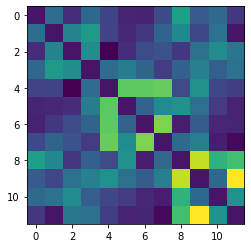

their


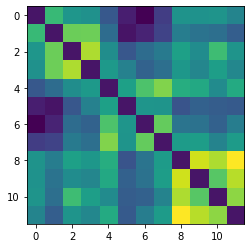

In [16]:
import torch
sentences1 = ['Motion control is assuming an increasingly pivotal role within modern large accelerator facilities, such as 4th generation storage ring-based light sources, SRF accelerators, and high-performance photon beamlines. For very high-Q SRF linacs, such as LCLS-II, the precise management of cavity resonance becomes indispensable for maintaining stable operations. Failing to do so would entail a significant upsurge in RF power requirements, consequently increasing operational and capital costs due to the necessity for additional RF power sources. We have developed an intelligent cavity resonance controller founded on a data-driven model, featuring an exceptionally lightweight surrogate mode engineered to address the intricate dynamics of forced cavities in the presence of microphonics and coupled with nonlinear Lorentz forces. The effectiveness of this mode has been rigorously validated through real SRF cavities at SLAC. We are currently in the process of implementing the controller on hardware, specifically the exiting LLRF system of LCLSII. Building on the success of this work, the model can be expanded to encompass general motion controls where exceptionally low-tolerance vibration is required. In this presentation, we will introduce the model and provide an overview of the latest test results.', 'During the operation of the Continuous Electron Beam Accelerator Facility (CEBAF), one or more unstable superconducting radio-frequency (SRF) cavities often cause beam loss trips while the unstable cavities themselves do not necessarily trip off. The present RF controls for the legacy cavities report at only 1 Hz, which is too slow to detect fast transient instabilities during these trip events. These challenges make the identification of an unstable cavity out of the hundreds installed at CEBAF a difficult and time-consuming task. To tackle these issues, a fast data acquisition system (DAQ) for the legacy SRF cavities has been developed, which records the sample at 5 kHz. A Principal Component Analysis (PCA) approach is being developed to identify anomalous SRF cavity behavior. We will discuss the present status of the DAQ system and PCA model, along with initial performance metrics. Overall, our method offers a practical solution for identifying unstable SRF cavities, contributing to increased beam availability and facility reliability.', 'Within the context of the European X-Ray Free-Electron Laser (EuXFEL), where 800 superconducting radio-frequency cavities (SRFCs) are employed to accelerate electron bunches to energies as high as 17.5 GeV, ensuring safe and optimal accelerator operation is crucial. In this work, we introduce a machine learning (ML)-enhanced approach for detecting anomalies, with a particular focus on identifying quenches, which can disrupt the superconductivity of the SRFCs, leading to operational interruptions. Our method consists of a two-stage analysis of the cavity dynamics. We first leverage analytical redundancy to process the data, and generate a residual for statistical testing and anomaly detection. Subsequently, we employ machine learning to distinguish quenching events from other anomalies. Different algorithms have been explored, and adapted in order to take into account the specificity of the data at hand. The evaluation, based on 2022 data, demonstrates the superior performance of our approach when compared to the currently deployed quench detection system.', 'In this study, we present a deep learning-based pipeline for predicting superconducting radio-frequency (SRF) cavity faults in the Continuous Electron Beam Accelerator Facility (CEBAF) at Jefferson Lab. We leverage pre-fault RF signals from C100-type cavities and employ deep learning to predict faults in advance of their onset. We train a binary classifier model to distinguish between stable and impending fault signals, where each cryomodule has a uniquely trained model. Test results show accuracies exceeding 99% in each of the six models for distinguishing between normal signals and pre-fault signals from a class of more slowly developing fault types, such as microphonics-induced faults. We describe results from a proof-of-principle demonstration on a realistic, imbalanced data set and report performance metrics. Encouraging results suggest that future SRF systems could leverage this framework and implement measures to mitigate the onset in more slowly developing fault types.']
sentences2 = ['Navigating the landscape of particle accelerators has become increasingly challenging with recent surges in contributions. These intricate devices challenge comprehension, even within individual facilities.    To address this, we introduce PACuna, a fine-tuned language model refined through publicly available accelerator resources like conferences, pre-prints, and books.    We automated data collection and question generation to minimize expert involvement and make the data publicly available.    PACuna demonstrates proficiency in addressing accelerator questions, validated by experts.    Our approach shows adapting language models to scientific domains by fine-tuning technical texts and auto-generated corpora capturing the latest developments can further produce pre-trained models to answer some specific questions that commercially available assistants cannot and can serve as intelligent assistants for individual facilities.', 'The Transformer is a deep learning architecture introduced in 2017, that has since then taken over the natural language processing field and has recently gained public popularity thanks to large language models like ChatGPT. The self-attention mechanism introduced with the Transformer allows it to learn complex patterns and relationships in data without explicitly using recurrent mechanisms like classic RNN-style architectures. While the Transformer was developed for sequence-to-sequence language modeling like translation tasks, the usefulness for time series prediction has been less explored in the machine learning community. Particularly, the lack of beginner-friendly tutorials and guides for using transformers with uni- and multivariate continuous input and outputs are not easily found online, as opposed to for natural language tasks. Therefore, this tutorial aims to introduce the Transformer architecture and how to use standard deep-learning library Transformer building blocks to construct a simple time series prediction model and explain the inputs and outputs of the transformer model. As an appendix, we will give a quick outlook of current state-of-the-art time series prediction architectures based on the basic Transformer as well as alternative modern time series forecasting methods.', 'The electronic logbook (elog) system used at Brookhaven National Laboratory’s Collider-Accelerator Department (C-AD) allows users to customize logbook settings, including specification of favorite logbooks. Using machine learning techniques, configurations can be further personalized to provide users with a view of entries that match their specific interests. Natural language processing (NLP) models are used to augment the elog system by classifying and finding similarities in entries. A command line interface tool is used to ease automation of NLP tasks in the controls system. A test web interface will be developed for users to enter phrases, terms, and sentences as search terms for the NLP models. The website will return useful information about a given search term. This technique will create recommendations for each user, filtering out unnecessary results generated by current search techniques.', 'Logbooks store important knowledge of activities and events that occur during accelerator operations. However, orientation and automation of accelerator logbooks can be challenging due to various challenges like very technical texts or content being hidden in images instead of text. As AI technologies like natural language processing continue to mature, they present opportunities to address these challenges in the context of particle accelerator logbooks.    In this work, we explore the potential use of state-of-the-art AI techniques in particle accelerator logbooks. Our goals are to help operators increase the FAIR-ness (findability, accessibility, interoperability, reusability) of logbooks by exploiting the multimodal information to make everyday use easier with multimodal LLM (large language models).']
sentences3 = ['Reinforcement learning is a form of machine learning in which intelligent agents learn to solve complex problems by gaining experience. In current research, agents trained with reinforcement learning perform better than their human counterparts on problems that have historically been difficult for machines to solve. Particle accelerators are among the most advanced high-tech machines in the world. Modern scientific experiments place the highest demands on beam quality, making particle accelerator control extremely complex. Reinforcement learning is a promising avenue of research that has the potential to improve existing accelerator control solutions and enable new ones that have previously been impossible with conventional methods. The barrier of entry into reinforcement learning, however, is high and slows its adoption in the accelerator field. In this tutorial, we apply reinforcement learning to the task of tuning transverse beam parameters in a real-world accelerator beam line and focus in particular on solving the issues that arise in the context of particle accelerators, such as the high cost of samples, a large sim2real gap and the high non-linearity of the control and optimisation tasks under investigation.', 'Reinforcement Learning (RL) is a unique learning paradigm that is particularly well-suited to tackle complex control tasks, can deal with delayed consequences, and learns from experience without an explicit model of the dynamics of the problem. These properties make RL methods extremely promising for applications in particle accelerators, where the dynamically evolving conditions of both the particle beam and the accelerator systems must be constantly considered.    While the time to work on RL is now particularly favourable thanks to the availability of high-level programming libraries and resources, its implementation in particle accelerators is not trivial and requires further consideration.    In this context, the Reinforcement Learning for Autonomous Accelerators (RL4AA) international collaboration was established to consolidate existing knowledge, share experiences and ideas, and collaborate on accelerator-specific solutions that leverage recent advances in RL.    The collaboration was launched in February 2023 during the RL4AA’23 workshop at the Karlsruhe Institute of Technology, and the second workshop is held in Salzburg, Austria in February 2024. These workshops feature keynote lectures by experts, technical presentations, advanced tutorials, poster sessions, and contributions on RL applications in various facilities. The next upcoming workshop will be held in February 2023 at DESY, Hamburg.', 'One of the key metrics determining the capabilities of Free Electron Laser (FEL) facilities is the intensity of photon beam they can provide to experiments. However, in day-to-day operations, tuning to maximise the FEL intensity is one of the most difficult and time-consuming tasks. Skilled human operators still need large amounts of the available beam time, which are then not available for experiments, to achieve maximum performance. The large number of tuning parameters and high non-linearity of the underlying dynamics have so far made it challenging to develop autonomous FEL tuning solutions. We present a method based on reinforcement learning to train a neural network policy to autonomously tune the FEL intensity at *LCLS* and *European XFEL*. Our method is trained requiring little to no beam time and is appealing for tuning across different FEL setups. In contrast to conventional black box optimisation approaches that do not share information across different tuning sessions and setups, a trained policy can leverage its experience to tune the FEL intensity with minimal online exploration.', 'Online tuning of particle accelerators is a complex optimisation problem that continues to require manual intervention by experienced human operators. Autonomous tuning is a rapidly expanding field of research, where learning-based methods like Bayesian optimisation (BO) hold great promise in improving plant performance and reducing tuning times. At the same time, Reinforcement Learning (RL) is a capable method of learning intelligent controllers, while recent work shows that RL can also be used to train domain-specialised optimisers in so-called Reinforcement Learning-      trained Optimisation (RLO). In parallel efforts, both algorithms have found successful adoption in particle accelerator tuning. Here we present a comparative case study, analysing the behaviours of both algorithms and outlining their strengths and weaknesses. The results of our study help provide criteria for choosing a suitable learning-based tuning algorithm for a given task and will accelerate research and adoption of these methods with particle accelerators and other complex real-      world facilities, ultimately improving their availability and pushing their operational limits, thereby enabling scientific and engineering advancements.']
sentences = []
sentences.extend(sentences1)
sentences.extend(sentences2)
sentences.extend(sentences3)

print('ours')
res = _eval(model1,sentences)
res -= torch.diag(torch.diag(res))
plt.imshow(res)
plt.show()
print('their')
res = _eval(model2,sentences)
res -= torch.diag(torch.diag(res))
plt.imshow(res)
plt.show()

In [17]:
sentences = [
    'BESSY',
    'DESY',
    'European XFEL',
    'PETRA'
    'HZB',
    'synchroton',
    'linac']
print('ours')
print(_eval(model1,sentences))
print('their')
print(_eval(model2,sentences))

ours
tensor([[1.0000, 0.6569, 0.2066, 0.5438, 0.1163, 0.1885],
        [0.6569, 1.0000, 0.2131, 0.4020, 0.2103, 0.1452],
        [0.2066, 0.2131, 1.0000, 0.1948, 0.1137, 0.1691],
        [0.5438, 0.4020, 0.1948, 1.0000, 0.0338, 0.1050],
        [0.1163, 0.2103, 0.1137, 0.0338, 1.0000, 0.2326],
        [0.1885, 0.1452, 0.1691, 0.1050, 0.2326, 1.0000]])
their
tensor([[1.0000, 0.3916, 0.1398, 0.2725, 0.1957, 0.1810],
        [0.3916, 1.0000, 0.1189, 0.2895, 0.2171, 0.1683],
        [0.1398, 0.1189, 1.0000, 0.1521, 0.1937, 0.2812],
        [0.2725, 0.2895, 0.1521, 1.0000, 0.1263, 0.2768],
        [0.1957, 0.2171, 0.1937, 0.1263, 1.0000, 0.3061],
        [0.1810, 0.1683, 0.2812, 0.2768, 0.3061, 1.0000]])
